In [98]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
patient = pd.read_csv("./moss_plos_one_data.csv")

In [3]:
#add shock index
patient.SBP.loc[patient.SBP ==0] = patient.SBP.mean()
patient["shockInd"] = patient.hr/patient.SBP


In [4]:
#create functions to calculate the probabilities
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)


In [5]:
patient.columns


Index(['id', 'age', 'race', 'svc', 'LOS', 'ICU_Pt_Days', 'Mort', 'n_evts',
       'eid', 'y', 'tte', 'death', 'direct', 'MET', 'Sgy',
       'Glasgow.Coma.Scale.Total', 'O2.Flow', 'Resp', 'SpO2', 'SBP', 'Pulse',
       'Temp', 'ALBUMIN', 'ALKALINE.PHOSPHATASE', 'ALT.GPT', 'AST.GOT',
       'BLOOD.UREA.NITROGEN', 'CALCIUM', 'CHLORIDE', 'CO2', 'CREATININE',
       'GLUCOSE', 'HEMOGLOBIN', 'LACTIC.ACID', 'MAGNESIUM',
       'OXYGEN.SATURATION', 'PARTIAL.THROMBOPLASTIN.TIME', 'PCO2',
       'PHOSPHORUS', 'PLATELET.COUNT', 'POTASSIUM', 'PROTIME.INR', 'SODIUM',
       'TOTAL.BILIRUBIN', 'TOTAL.PROTEIN', 'TROPONIN.I',
       'WHITE.BLOOD.CELL.COUNT', 'hr', 's2.hr', 's8.hr', 's24.hr', 'n.edrk',
       'edrk', 's2.edrk', 's8.edrk', 's24.edrk', 'srr', 'dfa', 'cosen', 'lds',
       'af', 'AF', 'shockInd'],
      dtype='object')

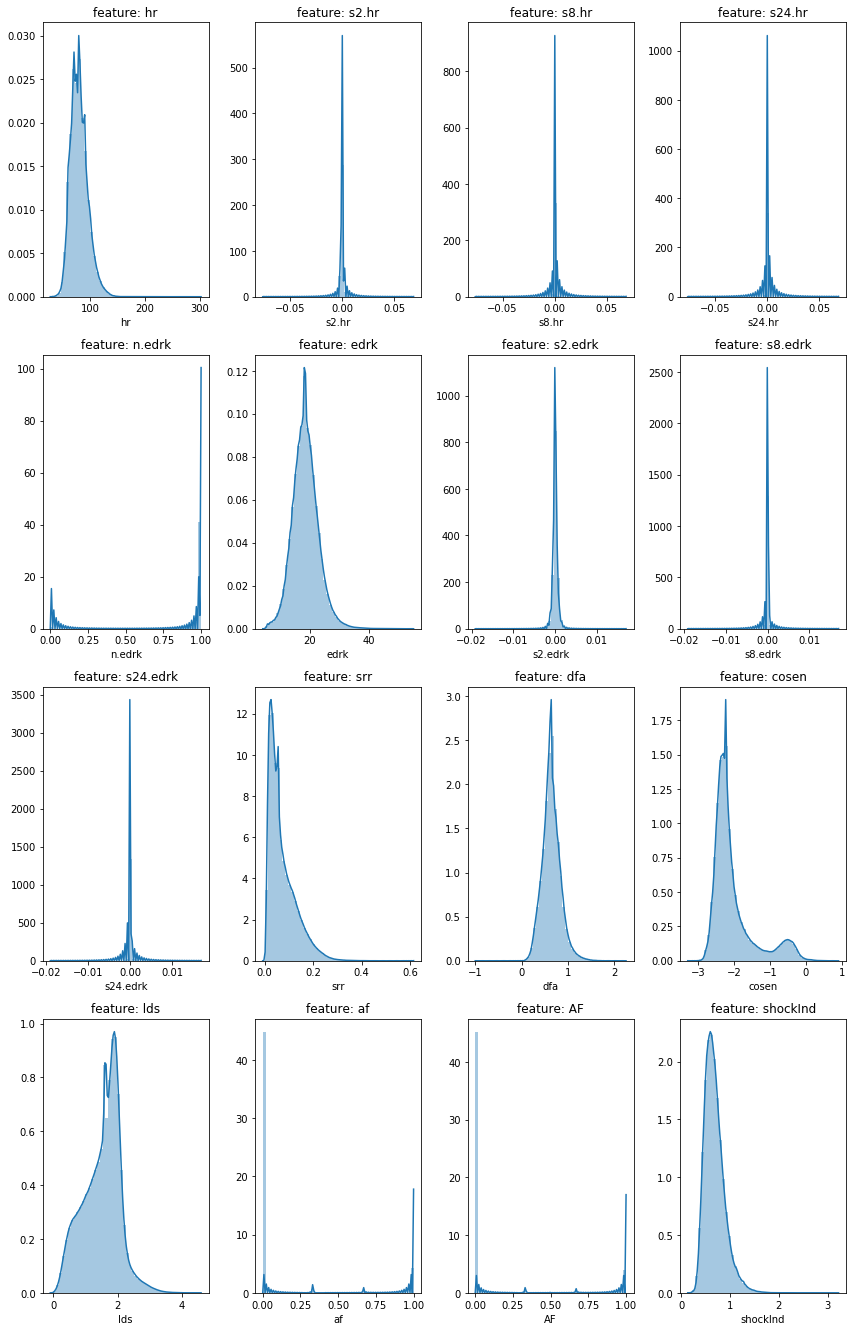

In [6]:
name = ['hr', 's2.hr', 's8.hr', 's24.hr', 'n.edrk',
       'edrk', 's2.edrk', 's8.edrk', 's24.edrk', 'srr', 'dfa', 'cosen', 'lds',
       'af', 'AF', 'shockInd']
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, col in enumerate(patient[name]):
    ax = plt.subplot(gs[i])
    sns.distplot(patient[col])
    ax.set_title('feature: ' + str(col))
plt.tight_layout()

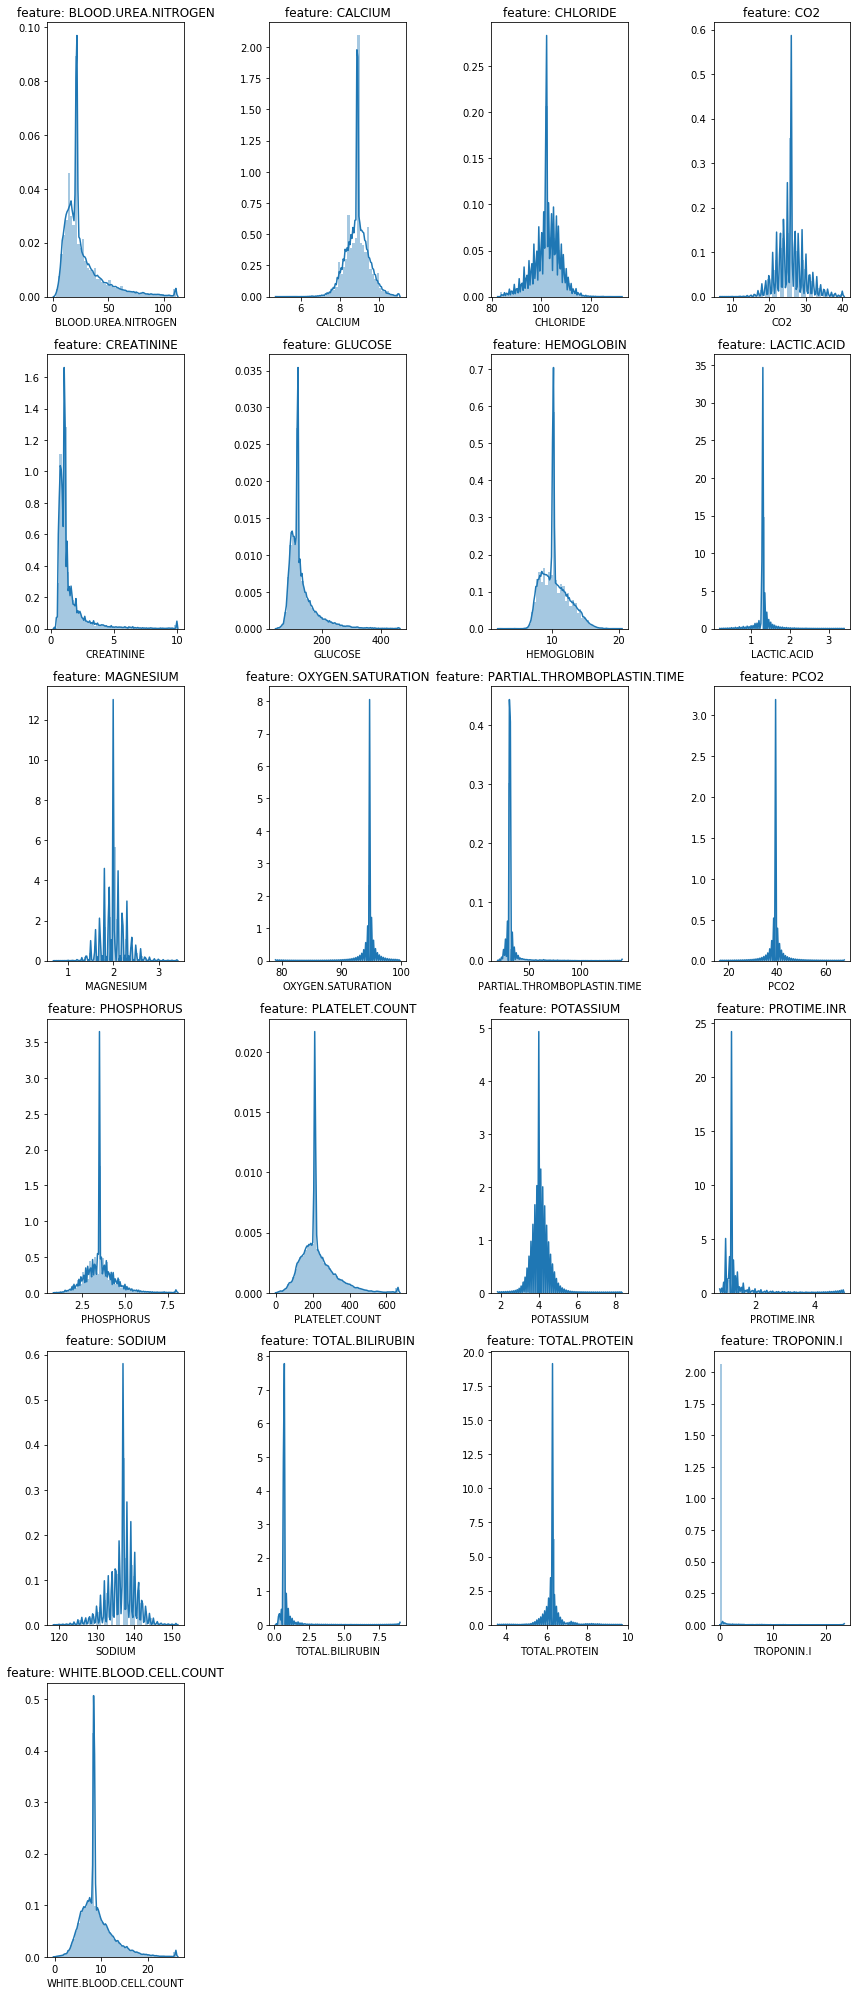

In [7]:
name = ['BLOOD.UREA.NITROGEN', 'CALCIUM', 'CHLORIDE', 'CO2', 'CREATININE',
       'GLUCOSE', 'HEMOGLOBIN', 'LACTIC.ACID', 'MAGNESIUM',
       'OXYGEN.SATURATION', 'PARTIAL.THROMBOPLASTIN.TIME', 'PCO2',
       'PHOSPHORUS', 'PLATELET.COUNT', 'POTASSIUM', 'PROTIME.INR', 'SODIUM',
       'TOTAL.BILIRUBIN', 'TOTAL.PROTEIN', 'TROPONIN.I',
       'WHITE.BLOOD.CELL.COUNT']
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, col in enumerate(patient[name]):
    ax = plt.subplot(gs[i])
    sns.distplot(patient[col])
    ax.set_title('feature: ' + str(col))
plt.tight_layout()

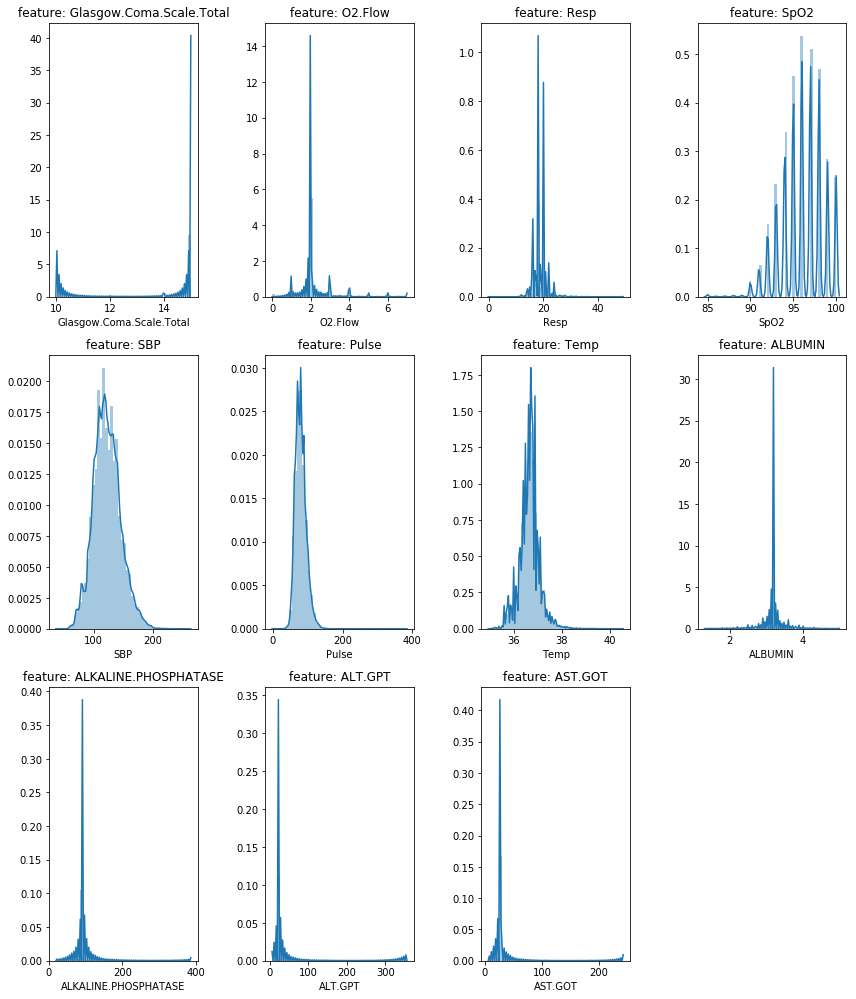

In [8]:
name = ['Glasgow.Coma.Scale.Total', 'O2.Flow', 'Resp', 'SpO2', 'SBP', 'Pulse',
       'Temp', 'ALBUMIN', 'ALKALINE.PHOSPHATASE', 'ALT.GPT', 'AST.GOT']
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(7, 4)
for i, col in enumerate(patient[name]):
    ax = plt.subplot(gs[i])
    sns.distplot(patient[col])
    ax.set_title('feature: ' + str(col))
plt.tight_layout()

In [124]:
#select columns
col = ['id','y','HEMOGLOBIN','WHITE.BLOOD.CELL.COUNT','PLATELET.COUNT','BLOOD.UREA.NITROGEN','shockInd']
# col = ['id','y','SpO2', 'SBP', 'Pulse','Temp','WHITE.BLOOD.CELL.COUNT','PLATELET.COUNT','MAGNESIUM','BLOOD.UREA.NITROGEN', 'CALCIUM', 'CHLORIDE', 'CO2','lds','hr','edrk','shockInd']
new_patient = patient.loc[:,col]

In [125]:
def select_threshold(probs, test_data):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs), max(probs), stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(test_data, predictions, average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon

    return best_f1, best_epsilon
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma
# mu, sigma = estimateGaussian(new_patient.head(2000))
# p = multivariateGaussian(new_patient.head(2000),mu,sigma)

# #selecting optimal value of epsilon using cross validation
# p_cv = multivariateGaussian(crossval_data,mu,sigma)
# fscore, ep = select_threshold(p_cv,test_data)
# print(fscore, ep)

# #selecting outlier datapoints
# outliers = np.asarray(np.where(p < ep))

In [126]:
#cross validation
unique_id = patient["id"].unique()#find all unique ids
true_id = patient["id"].loc[patient["y"] == True].unique()#367
false_id = np.array([num for num in unique_id if num not in true_id]) #7738
train_id =np.random.choice(unique_id, int(0.7*len(unique_id)), replace= False)
test_id = np.array([num for num in unique_id if num not in train_id])
cv_1 = unique_id[0:1200]
cv_2 = unique_id[1200:2400]
cv_3 = unique_id[2400:3600]
cv_4 = unique_id[3600:4800]
cv_5 = unique_id[4800:6000]
cv_6 = unique_id[6000:7739]


In [127]:
# new_patient2 = feature_normalize(new_patient.loc[:,~new_patient.columns.isin(["y","id"])])
new_patient2 = new_patient.loc[:,~new_patient.columns.isin(["y","id"])]
cv_train = new_patient2.loc[new_patient["id"].isin(cv_1), :]
cv_test = new_patient.loc[new_patient["id"].isin(cv_1), new_patient.columns.isin(["y"])]


In [128]:
mu, sigma = estimateGaussian(new_patient2)
# p_cv = multivariateGaussian(cv_train,mu,sigma)
# fscore, ep = select_threshold(p_cv,cv_test)

In [129]:
p_cv = multivariateGaussian(cv_train,mu,sigma)
fscore, ep = select_threshold(p_cv,cv_test)

In [130]:
p = multivariateGaussian(new_patient2,mu,sigma)

array(8.47757116e-08)

In [131]:
new_patient.loc[p<ep,"y"].sum()/new_patient.loc[p<ep,"y"].shape[0]

0.020075447113464893

In [132]:
new_patient.loc[p<ep,"y"].shape[0]

380664

In [133]:
new_patient.loc[p<ep,"y"].sum()

7642